In [ ]:
#

# Overview

- load contrast per participant
- parcelate
- average the scores
- plot it for margulies and contrast score. 

In [73]:
import os, glob
from os.path import join 
from nilearn import image
import numpy as np
import pandas as pd
from pathlib import Path
from neuromaps.parcellate import Parcellater
from neuromaps import transforms
from neuromaps.datasets import fetch_annotation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [48]:
nifti_save_dir = '/Users/h/Documents/projects_local/cue_expectancy/resources/plots_dissertation/SPM_univariate/6cond_highlowcue_rampupplateau';
pain_basename = 'model01-6cond_epoch-stim_dummy-cuelinearP_simple_STIM_cue_high_gt_low_t.nii'
vic_basename = 'model01-6cond_epoch-stim_dummy-cuelinearV_simple_STIM_cue_high_gt_low_t.nii'
cog_basename = 'model01-6cond_epoch-stim_dummy-cuelinearC_simple_STIM_cue_high_gt_low_t.nii'

pain_fname = join(nifti_save_dir, pain_basename)
vic_fname = join(nifti_save_dir, vic_basename)
cog_fname = join(nifti_save_dir, cog_basename)

In [49]:
pain_t = image.load_img(pain_fname)
vic_t = image.load_img(vic_fname)
cog_t = image.load_img(cog_fname)

In [50]:
from neuromaps.images import dlabel_to_gifti, annot_to_gifti
from neuromaps import transforms

hcplh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/lh.HCP-MMP1.annot')
hcprh = annot_to_gifti('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/rh.HCP-MMP1.annot')
HCP_fslr_lh = transforms.fsaverage_to_fslr(hcplh, hemi='L', target_density='32k', method='nearest')
HCP_fslr_rh = transforms.fsaverage_to_fslr(hcprh, hemi='R', target_density='32k', method='nearest')
HCP_fslr_rh_update = HCP_fslr_rh
HCP_fslr_rh_update[0].darrays[0].data = np.where(HCP_fslr_rh[0].agg_data() != 0, HCP_fslr_rh[0].agg_data() + 180, HCP_fslr_rh[0].agg_data())
hcp_glasser = (HCP_fslr_lh[0], HCP_fslr_rh_update[0])

# %% apply parcellation
canlab2023 = '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/CANLab2023_MNI152NLin6Asym_coarse_2mm_cifti_vols.nii.gz'

HCPparc = Parcellater(hcp_glasser, 'fsLR', resampling_target='parcellation')
subcortexparc = Parcellater(parcellation=canlab2023, 
                       space='MNI152', 
                       resampling_target='parcellation')

# df_beh = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep='\t')

/Users/h/Documents/projects_local


In [52]:
# transform mni contrast into flsr
pain_stim_fslr = transforms.mni152_to_fslr(pain_t, fslr_density='32k', method='linear')
vic_stim_fslr = transforms.mni152_to_fslr(vic_t, fslr_density='32k', method='linear')
cog_stim_fslr = transforms.mni152_to_fslr(cog_t, fslr_density='32k', method='linear')
margulies  = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k' )
# inverse transform pacellator
pain_parc = HCPparc.fit_transform(pain_stim_fslr, 'fsLR')
vic_parc = HCPparc.fit_transform(vic_stim_fslr, 'fsLR')
cog_parc = HCPparc.fit_transform(cog_stim_fslr, 'fsLR')
margulies_parc = HCPparc.fit_transform(margulies, 'fsLR')

In [94]:
data = pd.DataFrame({
    'pain': pain_parc.ravel(),
    'vicarious': vic_parc.ravel(),
    'cognitive': cog_parc.ravel(),
    'margulies': margulies_parc.ravel()
})

pcorr, p_value = pearsonr(data['margulies'], data['pain'])
vcorr, v_value = pearsonr(data['margulies'], data['vicarious'])
ccorr, c_value = pearsonr(data['margulies'], data['cognitive'])

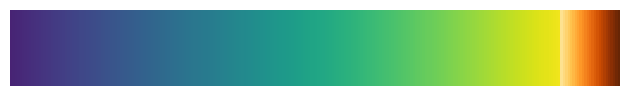

In [66]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

Text(0.35, 1.1, 'Pearson r = -0.16, p value = 0.003')

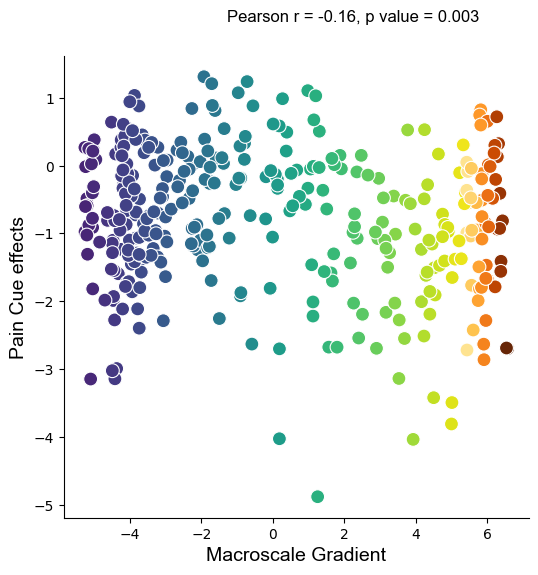

In [95]:
plt.figure(figsize=(6, 6))
scatter = sns.scatterplot(x='margulies', y='pain', hue='margulies', 
                          palette=mymap, data=data, s=100, legend=None)
sns.despine()
plt.xlabel('Macroscale Gradient', fontdict={'family': 'Arial', 'size': 14})
plt.ylabel('Pain Cue effects', fontdict={'family': 'Arial', 'size': 14})

text_str_p = f'Pearson r = {pcorr:.2f}, p value = {p_value:.3f}'
plt.text(0.35, 1.1, text_str_p, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', fontdict={'family': 'Arial'})

Text(0.35, 1.1, 'Pearson r = -0.72, p value = 0.000')

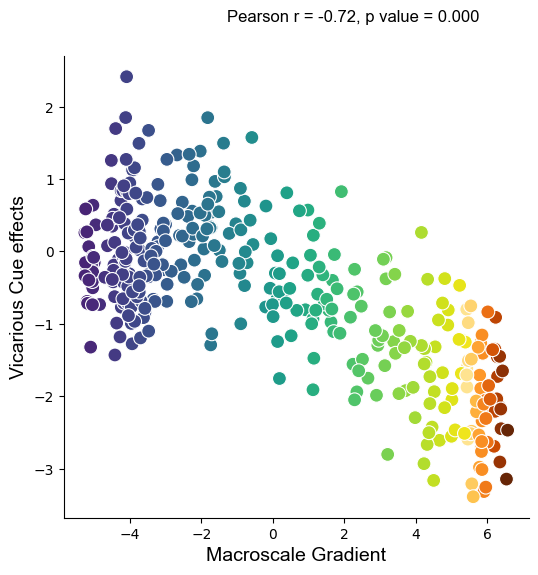

In [96]:
plt.figure(figsize=(6, 6))
scatter = sns.scatterplot(x='margulies', y='vicarious', hue='margulies', 
                          palette=mymap, data=data, s=100, legend=None)
sns.despine()
plt.xlabel('Macroscale Gradient', fontdict={'family': 'Arial', 'size': 14})
plt.ylabel('Vicarious Cue effects', fontdict={'family': 'Arial', 'size': 14})

text_str_v = f'Pearson r = {vcorr:.2f}, p value = {v_value:.3f}'
plt.text(0.35, 1.1, text_str_v, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', fontdict={'family': 'Arial'})

Text(0.35, 1.1, 'Pearson r = -0.09, p value = 0.086')

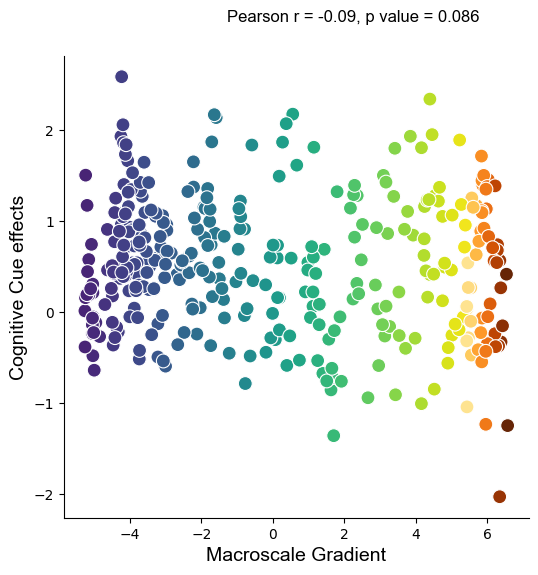

In [93]:
plt.figure(figsize=(6, 6))
scatter = sns.scatterplot(x='margulies', y='cognitive', hue='margulies', 
                          palette=mymap, data=data, s=100, legend=None)
sns.despine()
plt.xlabel('Macroscale Gradient', fontdict={'family': 'Arial', 'size': 14})
plt.ylabel('Cognitive Cue effects', fontdict={'family': 'Arial', 'size': 14})

# Format the text you want to display
text_str = f'Pearson r = {ccorr:.2f}, p value = {c_value:.3f}'
plt.text(0.35, 1.1, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', fontdict={'family': 'Arial'})
# bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)